# **CSE 7324 Lab 6: Convolutional Network Architectures**
### *Thomas Adams, Suleiman Hijazeen, Nancy Le and Andrew Whigham*
---

### **1. Preparation**
---


In [2]:
# import dependencies
from scipy import ndimage
import sys
import os
from time import time
from time import sleep
from PIL import Image
import numpy as np
import pandas as pd
import plotly
from plotly.graph_objs import Bar, Line
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs.scatter import Marker
from plotly.graph_objs.layout import XAxis, YAxis
import seaborn as sns
from IPython.display import Image as _Imgdis
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn import datasets as ds
import cv2  
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

In [3]:

import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__


'2.2.4'

In [4]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    
 

#### 1.1 Metric Evaluation
---

In [5]:
#create custom f1 metric from custom recall and precision
from keras.layers import concatenate
from keras import backend as K

def recall_m(y_true, y_pred): # recall is true positive / (total actual positive)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # actual positives are just y_true
        # recall is true positive / (total actual positive).. the episol is a small number to prevent divide by zero errors
        recall = true_positives / (possible_positives + K.epsilon()) 
        return recall

def precision_m(y_true, y_pred): #precision is true positives / (total predicted positives)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
        # (true positive / predicted positive).. the episol is a small number to prevent divide by zero errors
        precision = true_positives / (predicted_positives + K.epsilon())   
        return precision

def f1_m(y_true, y_pred): # f1 = 2 * (precision*recall / precision + recall)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) 

The metric we will use to determine the performance of our model will be the macro-averaged F1 score. We are using macro-averaging instead of micro even though we do not have a class imbalance problem. The number of instances for each class are 3000 

 in this project we are predecting what latter this sign is for using a set of pictures of ASL signes thus We are using F1 as we care both about precision and recall , either high False Positive or high False Negative leades to missunderstading of a latter that lead to a missunderstading in the whold word or sentenanse.

Since keras does not provide recall, precision, or f1 in their metrics package as a result of the 2.0 release, we will need to implement our own custom metric. Keras removed these functions as they are global metrics which were being approximated in batches (as keras runs in batches). However, for our purposes, this approximation will suffice. We found the following post on datascience stackexchange which helped detail this process below. Though fairly straightforward, we have provided comments to explain the code we have leveraged.

https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

https://github.com/keras-team/keras/wiki/Keras-2.0-release-notes


In [6]:
asl = pd.read_csv("data/asl_alphabet_train_50.csv")

y=asl.drop(asl.columns[1:], axis=1)
asl=asl.drop(asl.columns[0], axis=1)
asl.shape
yasl=np.asarray(asl)

In [7]:
X_train = np.expand_dims(yasl.reshape((-1,50,50)), axis=3)

#### 1.2 Splitting Data
---

In [8]:
img_wh=50
NUM_CLASSES=29
X_ar=np.asarray(asl)
y_ar=np.asarray(y)
X_train, X_test, y_train, y_test=train_test_split(X_ar,y_ar, test_size=0.2)
X_train_d = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test_d = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)

print(y_train.shape)
print(X_train.shape)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)


(69599, 1)
(69599, 2500)


#### Split the Data
Here we will split the training and test datasets. Since we have almost 80k instances of data, the likelihood that we will use ~64k unrepresentative examples is extremely small. Thus, we have opted for the simple 80/20 split.

since we got 3000 train picture for each alphabet so I believe this is enough figure to go with a simple 80 20 split  



### **2. Modeling**
---

#### 2.1 CNN with Keras and Data Expansion
---

In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=1, # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.1,#Range for random zoom
    channel_shift_range=0.1,#Range for random channel shifts.
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train_d)

idx = 0

the code above will alter our training data so that for each epoces you are always dealing with new data, we decide to generate different pictures by changing the following:

1- rotation_range: which is routing the picture by a certain value of degrees, we decicde to be 10 because more than that might introduce confusion with other ASL signs

2- height_shift_range: inducing a random horizontal shifts we decided to stay with .1 (mean shift .1 fraction of the total height ) because we don't to loss any features in the picture by adding high shifts 

3- width_shift_range: introducing a random vertical shifts we decided to stay with .1 (mean shift .1 fraction of the total width) because we don't lose any features in the picture by adding high shifts 

4- shear_range: adding a sheer intensity, we believe adding shear will give better mimicry to real cases of destortion to an image 

5- zoom_range: introducing random zoom which is a good representation to a distortion might happen to a picture where not the whole hand is visible 

6- channel_shift_range: random channel shifts, this might not affect the picture but we thought its good element to add if colors would be introduced in the future 

[22]


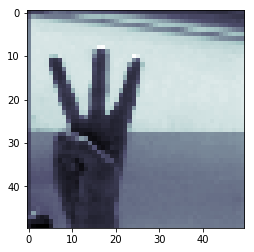

In [17]:
plt.imshow(X_train_d[3000].squeeze(),cmap='bone')
print(y_train[3000])

/home/andrew/anaconda3/envs/mlenv/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning:

Float image out of standard range; displaying image with stretched contrast.



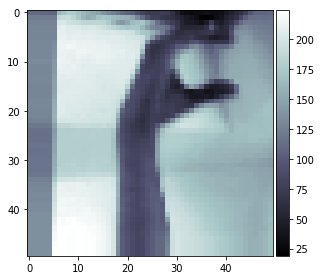

In [18]:
tmps = datagen.flow(X_train_d, y_train_ohe, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='bone')
   
    break

#### 2.2 Comparing CNNs with Different Parameters
---

In [19]:
# what if we just want to use the validation data??
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
l2_lambda = 0.0001

# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn = Sequential()

cnn.add(Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',
               data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=128,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
    

# add one layer on flattened output

cnn.add(Flatten())
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['acc', f1_m])

# the flow method yields batches of images indefinitely, with the given transofmrations



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
history =cnn.fit_generator(datagen.flow(X_train_d, y_train_ohe, batch_size=32), 
                  steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                  epochs=50, verbose=1,
                  validation_data=(X_test_d,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )

             

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 893/2174 [===========>..................] - ETA: 4:19 - loss: 6.5173 - acc: 0.0482 - f1_m: 0.0128

KeyboardInterrupt: 

In [ ]:
summarize_net(cnn, X_test_d, y_test, title_text='Using Expansion:')

In [ ]:
%%time

from keras.layers import average, concatenate
from keras.models import Input, Model

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.summary()

In [ ]:
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['acc', f1_m])

In [ ]:
history2 =cnn_ens.fit_generator(datagen.flow(X_train_d, y_train_ohe, batch_size=128), 
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=50, verbose=1,
                  validation_data=(X_test_d,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )


In [ ]:
summarize_net(cnn_ens, X_test_d, y_test, title_text='Using Expansion:')

In [ ]:
# Xception style architecture
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model

l2_lambda = 0.000001



input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])
x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x_split)


x = SeparableConv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])
x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x_split)
x_split = SeparableConv2D(filters=128,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)
x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.summary()

In [ ]:
# speed up by training by not using augmentation, perhaps there are faster ways??
xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['acc', f1_m])


In [ ]:
history3 =xception.fit_generator(datagen.flow(X_train_d, y_train_ohe, batch_size=32), 
                  steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                  epochs=50, verbose=1,
                  validation_data=(X_test_d,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                 )

In [ ]:
summarize_net(xception, X_test_d, y_test, title_text='Using Expansion:')

#### 2.3 Visualize Results
---

In [ ]:
plt.figure(figsize=(15,11))
plt.subplot(2,3,1)
plt.ylabel('5 layers CNN acc and val_acc')
plt.xlabel('epochs CNN')
plt.plot(history.history['f1_m'])

plt.plot(history.history['val_f1_m'])


plt.subplot(2,3,4)
plt.plot(history.history['loss'])
plt.ylabel('5 layers CNN acc and val_acc')
plt.plot(history.history['val_loss'])
plt.xlabel('epochs CNN')


plt.subplot(2,3,2)
plt.ylabel('Ensemble Nets acc and val_acc')
plt.xlabel('epochs Ensemble')
plt.plot(history2.history['f1_m'])

plt.plot(history2.history['val_f1_m'])


plt.subplot(2,3,5)
plt.plot(history2.history['loss'])
plt.ylabel('Ensemble Nets Loss and val_loss')
plt.plot(history2.history['val_loss'])
plt.xlabel('epochs Ensemble')

plt.subplot(2,3,3)
plt.ylabel('Xception Nets acc and val_acc')
plt.xlabel('epochs Xception')
plt.plot(history3.history['f1_m'])

plt.plot(history3.history['val_f1_m'])


plt.subplot(2,3,6)
plt.plot(history3.history['loss'])
plt.ylabel('Xception Nets Loss and val_loss')
plt.plot(history3.history['val_loss'])
plt.xlabel('epochs Xception')

from the figures above the following, we found out that network in network Ensemble is the best in terms of loss and validation accuract, 

Xception did the worst in this set even though we have more than 77 thousand parameters to optimize 

#### 2.4 Comparing CNN Performance with MLP
---

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        X_test_d = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
        yhat_cnn = np.argmax(cnn.predict(X_test_d), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

In [ ]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

In [ ]:
print(X_test.shape)
print(y_test.flatten().shape)

compare_mlp_cnn(cnn,mlp,X_test,y_test)

### **3. Exceptional Work: Transfer Learning**
---

In [9]:
from keras.models import Sequential, Model, Input
from keras.applications.vgg19 import VGG19, decode_predictions, preprocess_input
from keras.layers import SeparableConv2D, Add, Flatten, Dense, average, concatenate
from keras.layers.normalization import BatchNormalization
from skimage.transform import resize
from scipy.misc import imresize
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# copy train and test sets
x_train = X_train_d.copy()
x_test = X_test_d.copy()

print(x_train.shape)

(69599, 50, 50, 1)


In [10]:
# upsample images
#x_train_up = [imresize(x, size=(50,50,3), interp='nearest') for x in x_train]
x_train_up = [resize(x, (64,64,3), anti_aliasing=True) for x in x_train]
x_train_up = np.stack(x_train_up, axis=0)
print(x_train_up.shape)

#x_test_up = [imresize(x, size=(50,50,3), interp='nearest') for x in x_test]
x_test_up = [resize(x, (64,64,3), anti_aliasing=True) for x in x_test]
x_test_up = np.stack(x_test_up, axis=0)
print(x_test_up.shape) 

model = VGG19(include_top=False, weights='imagenet')

x = x_train_up[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time 
preds = model.predict(x)
preds.shape

(69599, 64, 64, 3)
(17400, 64, 64, 3)
Instructions for updating:
Colocations handled automatically by placer.
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


(1, 2, 2, 512)

In [11]:
x_train_up = preprocess_input(x_train_up)
x_test_up = preprocess_input(x_test_up)

In [12]:
%%time

x_train_vgg = model.predict(x_train_up)
x_test_vgg = model.predict(x_test_up)
print(x_train_vgg.shape)

(69599, 2, 2, 512)
CPU times: user 3h 14min 11s, sys: 8min 48s, total: 3h 23min
Wall time: 26min 37s


In [14]:
input_x = Input(shape=x_train_vgg[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu', kernel_initializer='he_uniform')(x)
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model2 = Model(inputs=input_x, outputs=predictions)

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               409800    
_________________________________________________________________
dense_3 (Dense)              (None, 29)                5829      
Total params: 415,629
Trainable params: 415,629
Non-trainable params: 0
_________________________________________________________________


In [16]:
y_train_ohe_vgg = y_train_ohe[:x_train_vgg.shape[0]]

model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model2.fit(x_train_vgg, y_train_ohe_vgg, 
           epochs=5, batch_size=64, verbose=1, 
           validation_data=(x_test_vgg, y_test_ohe[:x_test_vgg.shape[0]]))


Instructions for updating:
Use tf.cast instead.
Train on 69599 samples, validate on 17400 samples
Epoch 1/5
69599/69599 [==============================] - 4s 58us/step - loss: 3.5081 - acc: 0.0338 - val_loss: 3.3676 - val_acc: 0.0322
Epoch 2/5
69599/69599 [==============================] - 4s 56us/step - loss: 3.3678 - acc: 0.0334 - val_loss: 3.3676 - val_acc: 0.0322
Epoch 3/5
69599/69599 [==============================] - 4s 57us/step - loss: 3.3676 - acc: 0.0342 - val_loss: 3.3676 - val_acc: 0.0322
Epoch 4/5
69599/69599 [==============================] - 4s 56us/step - loss: 3.3677 - acc: 0.0339 - val_loss: 3.3676 - val_acc: 0.0340
Epoch 5/5
69599/69599 [==============================] - 4s 57us/step - loss: 3.3677 - acc: 0.0335 - val_loss: 3.3676 - val_acc: 0.0328


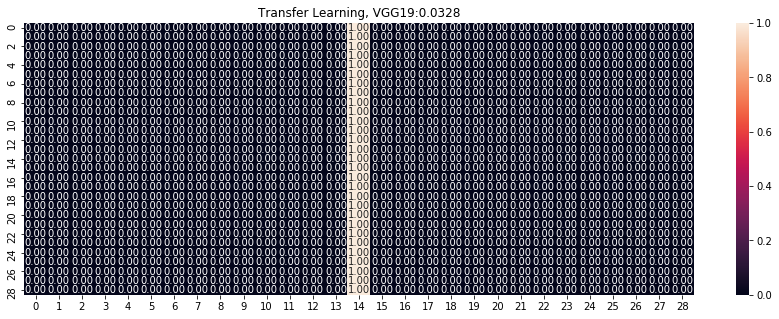

In [17]:
summarize_net(model2, x_test_vgg, y_test[:x_test_vgg.shape[0]], title_text='Transfer Learning, VGG19:')

### **4. References**
---